# Imports and Paths

In [1]:
import os
import pandas as pd
import sys
import numpy as np
from sklearn.ensemble import *

In [2]:
%load_ext autoreload
%autoreload 2

In [15]:
if os.name == 'nt':
    PATH_base = 'E:\\GitHub\\data_science\\'
    PATH_bd = 'E:\\GitHub\\data_science\\data\\uncompressed\\blue_book_for_bulldozers\\'
    PATH_func = 'E:\\GitHub\\data_science\\src\\'
elif os.name == 'posix':
    PATH_base = '/home/msnow/git/data_science/'
    PATH_bd = '/data/msnow/data_science/blue_book_for_bulldozers/'
    PATH_func = PATH_base + 'src/'

In [10]:
sys.path.append(PATH_func)

In [70]:
from features.imports import *
from features.utilities import *
from features.fastai import *


In [10]:
%ls ..\\data\\uncompressed\\blue_book_for_bulldozers\\

 Volume in drive E is Storage
 Volume Serial Number is D098-4C8A

 Directory of E:\GitHub\data_science\data\uncompressed\blue_book_for_bulldozers

03/24/2018  04:37 PM    <DIR>          .
03/24/2018  04:37 PM    <DIR>          ..
01/24/2013  09:08 PM       116,403,970 Train.csv
01/24/2013  07:11 PM         3,318,969 Valid.csv
               2 File(s)    119,722,939 bytes
               2 Dir(s)  1,852,864,679,936 bytes free


# Initial Data Munging

This dataset is from the kaggle competition [Blue Book for Bulldozers](https://www.kaggle.com/c/bluebook-for-bulldozers).  

In [16]:
df_raw = pd.read_csv(f'{PATH_bd}Train.csv', low_memory=False, parse_dates=["saledate"])

In [17]:
# df_raw.to_feather(f'{PATH_bd}bulldozer_raw')
# df_orig = df_raw.copy()
# df_raw = df_orig

In [18]:
display_some(df_raw.head().T,80,10)

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000,57000,10000,38500,11000
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


## Metrics

In this competition, the goal is to predict the SalePrice and the metric used is the root mean squared log error (RMSLE).  Therefore, I will convert the SalePrice column into the log of the SalePrice

In [19]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

## Splitting Datetime

Split the dattime column `saledate` into multiple columns containing integer components of the datetime, e.g., year, month, day, day of week, weekend

In [20]:
add_datepart(df_raw, 'saledate')

## Convert Strings to Integer Categorical 

Convert all columns with string values to integer categorical variables

In [21]:
train_cats(df_raw)

In [22]:
df_raw.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

When there is ordinality in the strings you can assign the categorical integer values to share that order

In [23]:
df_codes = df_raw.UsageBand.cat.codes
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

In [24]:
df_UsageBand_cat = pd.DataFrame({'Raw':df_raw.UsageBand, 'Unordered':df_codes, 'Ordered':df_raw.UsageBand.cat.codes})
df_UsageBand_cat.head()

,Ordered,Raw,Unordered
0,2,Low,1
1,2,Low,1
2,0,High,0
3,0,High,0
4,1,Medium,2


In [25]:
df, y, na_dict = proc_df(df_raw, 'SalePrice')

## Save to/Load from Feather

In [20]:
# df_raw.to_feather(f'{PATH_base}\\data\\interim\\bulldozer')
# df_raw = pd.read_feather(f'{PATH_base}\\data\\interim\\bulldozer')

# Random Forest

## $r^2$ and RMSE

In [26]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df, y)

0.9830584852451669

This score is the $r^2$ which is defined as :

$$r^2 = 1-\dfrac{SS_{res}}{SS_{tot}}  = 1-\dfrac{\sum\limits_i\left(y_i-f_i\right)^2}{\sum\limits_i\left(y_i-\bar{y}\right)^2}$$

where $y_i$ is the true output, $f_i$ is the model output and $\bar{y}$ is the mean true output.  Intepretation of different $r^2$ values is as follows
  1. $r^2 = 1$ means that the model perfectly predicts the output
  1. $r^2 = 0$ means the model does no better than predicting the output using the mean output, i.e., $\bar{y}$
  1. $1 > r^2 > 0 $ means that the model is better than simply using the mean ouptut
  1. $r^2 < 0$ means that the model is worse than just using the mean output as a predictor
 
However, $r^2$ by itself, is not a good metric as an overfit model will have an $r^2$ close to 1 for the training set, but would do much worse on a test set. 

To overcome the issue of overfitting, we can split the data into a training and validation set; using the training set to build the model and the validation set to test how good the model does on a different set of data.

In [27]:
n_trn = len(df)-12000
X_train, X_valid = split_train_val(df,trn_amount=n_trn)
y_train, y_valid = split_train_val(y,trn_amount=n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

In [28]:
train_rmse = custom_RFscore(m, X_train, y_train)
valid_rmse = custom_RFscore(m, X_valid, y_valid) 
train_score = m.score(X_train, y_train)
valid_score = m.score(X_valid, y_valid)
print(f'Training rmse: {train_rmse}')
print(f'Validation rmse: {valid_rmse}')
print(f'Training Score: {train_score}')
print(f'Validation Score: {valid_score}')

Training rmse: 0.0901980521214987
Validation rmse: 0.09293991828616852
Training Score: 0.9829968594917244
Validation Score: 0.9845740277204695


## Speeding Things Up

In [76]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=na_dict)
X_train, _ = split_train_val(df_trn, trn_amount=20000)
y_train, _ = split_train_val(y_trn, trn_amount=20000)

In [77]:
m = RandomForestRegressor(n_jobs=-1);
m.fit(X_train, y_train);

In [36]:
train_rmse = custom_RFscore(m, X_train, y_train)
valid_rmse = custom_RFscore(m, X_valid, y_valid) 
train_score = m.score(X_train, y_train)
valid_score = m.score(X_valid, y_valid)
print(f'Training rmse: {train_rmse}')
print(f'Validation rmse: {valid_rmse}')
print(f'Training Score: {train_score}')
print(f'Validation Score: {valid_score}')

Training rmse: 0.11620681946009107
Validation rmse: 0.27980858081774207
Training Score: 0.972234615315202
Validation Score: 0.860179763784176


In [37]:
def print_custom_RFscore():
    train_rmse = custom_RFscore(m, X_train, y_train)
    valid_rmse = custom_RFscore(m, X_valid, y_valid) 
    train_score = m.score(X_train, y_train)
    valid_score = m.score(X_valid, y_valid)
    print(f'Training rmse: {train_rmse}')
    print(f'Validation rmse: {valid_rmse}')
    print(f'Training Score: {train_score}')
    print(f'Validation Score: {valid_score}')

## Single Tree

In [78]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_custom_RFscore()

Training rmse: 0.5364456550655531
Validation rmse: 0.5735330509192927
Training Score: 0.40281221005865697
Validation Score: 0.41255816207663254


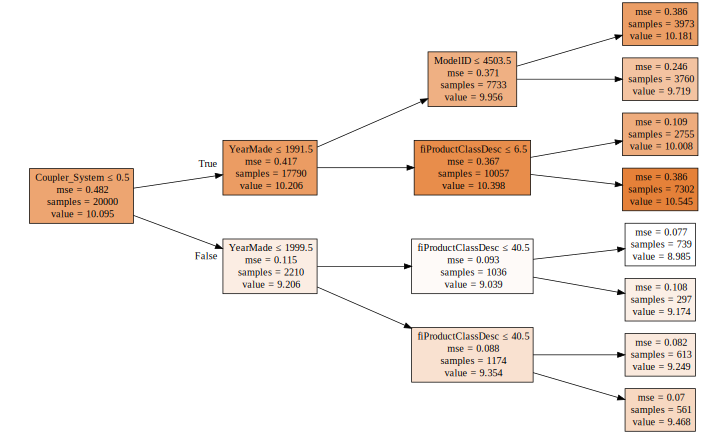

In [79]:
draw_tree(m.estimators_[0], df_trn, precision=3)

### Interpreting the Decision Tree

If I took the mean output of my entire dataset and used that to predict the output for each individual observation, what would the mean square error be?

In [98]:
mse = ((y_train - y_train.mean())**2).mean()
print(f'mean square error = {round(mse,3)}')
print(f'samples = {len(y_train)}')
print(f'mean value = {round(y_train.mean(),3)}')

mean square error = 0.482
samples = 20000
mean value = 10.095


Taking a look at the tree above, we can now see that the `values` and `mse` term of the first box correspond to the mean output value and mean squared error using the output value of the entire dataset. Let's see if this analysis holds true for the next couple of boxes.

In [99]:
y_train_2_1 = y_train[list(X_train.Coupler_System <= 0.5)]
mse = ((y_train_2_1 - y_train_2_1.mean())**2).mean()
print(f'mean square error = {round(mse,3)}')
print(f'samples = {len(y_train_2_1)}')
print(f'mean value = {round(y_train_2_1.mean(),3)}')

mean square error = 0.417
samples = 17790
mean value = 10.206


In [111]:
y_train_2_2 = y_train[list(X_train.Coupler_System > 0.5 )]
mse = ((y_train_2_2 - y_train_2_2.mean())**2).mean()
print(f'mean square error = {round(mse,3)}')
print(f'samples = {len(y_train_2_2)}')
print(f'mean value = {round(y_train_2_2.mean(),3)}')

mean square error = 0.115
samples = 2210
mean value = 9.206


In [110]:
y_train_3_1 = y_train[list((X_train.Coupler_System <= 0.5)  & (X_train.YearMade <= 1991.5))]
mse = ((y_train_3_1 - y_train_3_1.mean())**2).mean()
print(f'mean square error = {round(mse,3)}')
print(f'samples = {len(y_train_3_1)}')
print(f'mean value = {round(y_train_3_1.mean(),3)}')

mean square error = 0.371
samples = 7733
mean value = 9.956


In [114]:
X_train.Coupler_System.unique()

array([0, 1, 2])